In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd

from shutil import move
from tqdm import tqdm#_notebook as tqdm

from models.MikkelAE import MikkelAE
from models.BaseModel import BaseModel

from utils import plot, check_memory_usage
from myDataLoader import myDataLoader

import matplotlib
import matplotlib.pyplot as plt

%matplotlib nbagg
%matplotlib inline

cuda = torch.cuda.is_available()
cuda

True

In [50]:
imgSize = (240,240)
np.prod(imgSize)*3

172800

In [67]:
import torch.nn as nn
from torch.nn.functional import softplus

# define size variables
num_features = np.prod(imgSize)*3

class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x
    

class unFlatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], 128, 56, 56)
        return x

class VariationalAutoencoder(BaseModel):
    def __init__(self, latent_features, num_samples):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=2, padding=0),
            nn.ReLU(),
            Flatten(),
            nn.Linear(in_features=401408, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean and variance
            nn.Linear(in_features=128, out_features=2*self.latent_features) # <- note the 2*latent_features
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=401408),
            nn.ReLU(),
            unFlatten(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=7, stride=2, padding=0,output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=7, stride=2, padding=0,output_padding=1),
            nn.ReLU(),
        )
        

    def forward(self, x): 
        orig_shape = x.shape
        #x = x.view((x.shape[0],-1))
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        
        # Make sure that the log variance is positive
        log_var = softplus(log_var)
        
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.num_samples, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        sigma = torch.exp(log_var/2)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        
        z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)     
        z = z.view(5,-1)
        # Run through decoder
        x = self.decoder(z)
        
        # The original digits are on the scale [0, 1]
        x = torch.sigmoid(x)
        # Mean over samples
        #x_hat = torch.mean(x, dim=1)
        x_hat = x.view(orig_shape)
        
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs


latent_features = 2
num_samples = 1

net = VariationalAutoencoder(latent_features, num_samples)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

from torch.nn.functional import binary_cross_entropy
from torch import optim

def ELBO_loss(y, t, mu, log_var):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()


# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss
    
print(net)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=401408, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=401408, bias=True)
    (3): ReLU()
    (4): unFlatten()
    (5): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(64, 3, kernel_size=(7, 7), stride=(2, 2), output_padding=(1, 1))
    (8): ReLU()
  )
)


In [2]:
net = MikkelAE()
if cuda:
    net = net.cuda()

optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_function = nn.MSELoss()

print(net)

MikkelAE(
  (c1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mup1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (ct1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (ct2): ConvTranspose2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
  (mup2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (ct3): ConvTranspose2d(64, 3, kernel_size=(7, 7), stride=(1, 1))
)


In [68]:
from torch.autograd import Variable
loader = myDataLoader(batchSize = 5, imgSize = imgSize)
# test the forward pass
# expect output size of [32, num_features]
#flatten = lambda x: ToTensor()(x).view(np.prod(imgSize))
batch = loader.getNext()
#batch.imgs = np.array([img.flatten() for img in batch.imgs])
x = Variable(torch.from_numpy(batch.imgs).float())
x = x.permute((0,3,1,2))
print(x.shape)
if cuda:
    x = x.cuda()

outputs = net(x)
print(outputs['x_hat'].shape)

Starting DataLoader...
941 images found
Split into 752 train and 189 validation images with seed 42
torch.Size([5, 3, 240, 240])
torch.Size([5, 3, 240, 240])


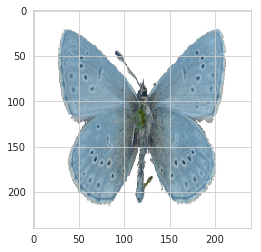

In [69]:
batch = loader.getNext()
batch.imgs[0].shape
plt.imshow(batch.imgs[0])

Model Improved, saving model.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


28 / 100


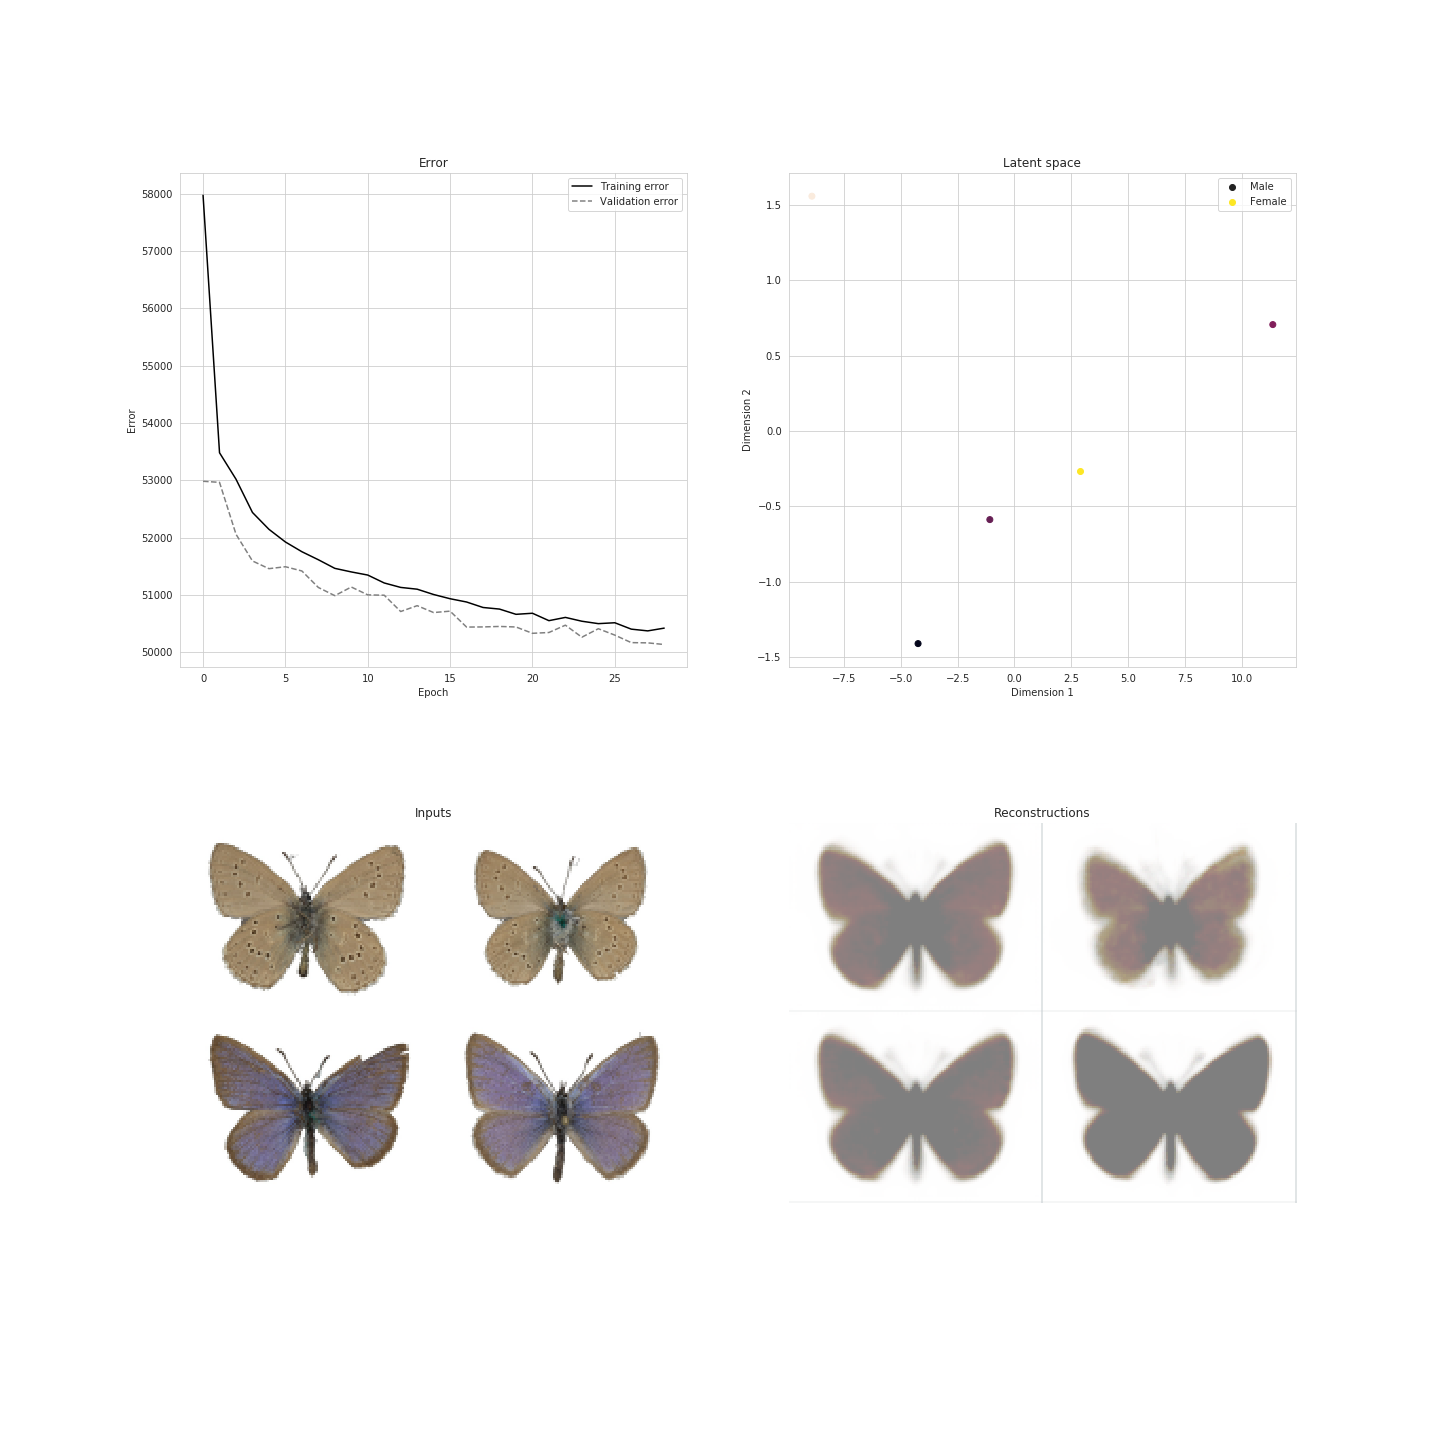

In [ ]:
import os
imgSize = (240,240)
batchSize = 5
earlyStopping = 5
max_num_epochs = 100

loader = myDataLoader(batchSize = batchSize, imgSize = imgSize)
modelFolder = '/home/rob/Dropbox/thesis/2. code/src/experiments'

assert os.path.exists(modelFolder), "Cannot find model folder, abort!"

best_val_loss = float('inf')
noImprovementSince = 0
train_losses = []
valid_losses = []

flatten = lambda x: ToTensor()(x).view(np.prod(imgSize))
for epoch in range(max_num_epochs):
    net.train()
    loader.trainSet()
    _, numBatches = loader.getIteratorInfo()
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    batch_losses = []
    for i in range(numBatches):
        batch = loader.getNext()
        x = Variable(torch.from_numpy(batch.imgs).float())
        x = x.permute((0,3,1,2))
        if cuda:
            x = x.cuda()
        outputs = net(x)
        #x_hat = outputs['x_hat']

        # note, target is the original tensor, as we're working with auto-encoders
        #loss = loss_function(x_hat, x)
        x_hat = outputs["x_hat"]
        mu, log_var = outputs["mu"], outputs["log_var"]
        z = outputs["z"]

        loss, kl = loss_function(x_hat, x, mu, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())

    train_losses.append(np.mean(batch_losses))
    
    # Evaluate, do not propagate gradients
    loader.validationSet()
    _, numBatches = loader.getIteratorInfo()
    with torch.no_grad():
        net.eval()
        
        batch_losses = []
        for i in range(numBatches):
            # Just load a single batch from the test loader
            batch = loader.getNext()
            x = Variable(torch.from_numpy(batch.imgs).float())
            x = x.permute((0,3,1,2))

            if cuda:
                x = x.cuda()

            outputs = net(x)

            #x_hat = outputs['x_hat']
            #z = outputs['z'].cpu().numpy()

            #loss = loss_function(x_hat, x)
            x_hat = outputs["x_hat"]
            mu, log_var = outputs["mu"], outputs["log_var"]
            z = outputs["z"]

            loss, kl = loss_function(x_hat, x, mu, log_var)
            
            
            x = x.to("cpu")
            x_hat = x_hat.to("cpu")
            z = z.detach().to("cpu").numpy()

            batch_losses.append(loss.item())
        valid_loss = np.mean(batch_losses)
        valid_losses.append(valid_loss)
    
    if valid_loss < best_val_loss:
        noImprovementSince = 0
        modelName = str(net.__class__.__name__)
        fp = os.path.join(modelFolder,modelName+'.pth.tar')
        print('Model Improved, saving model.')
        net.save({
            'epoch':epoch,
            'state_dict':net.state_dict(),
            'optimizer_dict':optimizer.state_dict(),
            'best_valid_loss':valid_loss,
            'train_losses':train_losses,
            'valid_losses':valid_losses},fp)
        best_val_loss = valid_loss
    else:
        noImprovementSince += 1
    
    
    if epoch == 0:
        continue
        
    print(epoch, '/', max_num_epochs)
    plot(train_losses,valid_losses,x,x_hat,z,batch,epoch,batchSize)
    
    if noImprovementSince >= earlyStopping:
        print(f'No improvement on validation set for {earlyStopping} epochs. Quiting.')
        break

newModelName = '%06.0f'%(best_val_loss*100000) + '_' + str(pd.Timestamp.now().date()) + '_' + net.__class__.__name__ 
new_fp = os.path.join(modelFolder,newModelName+'.pth.tar')
move(fp,new_fp)    
plot(train_losses,valid_losses,x,x_hat,z,batch)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


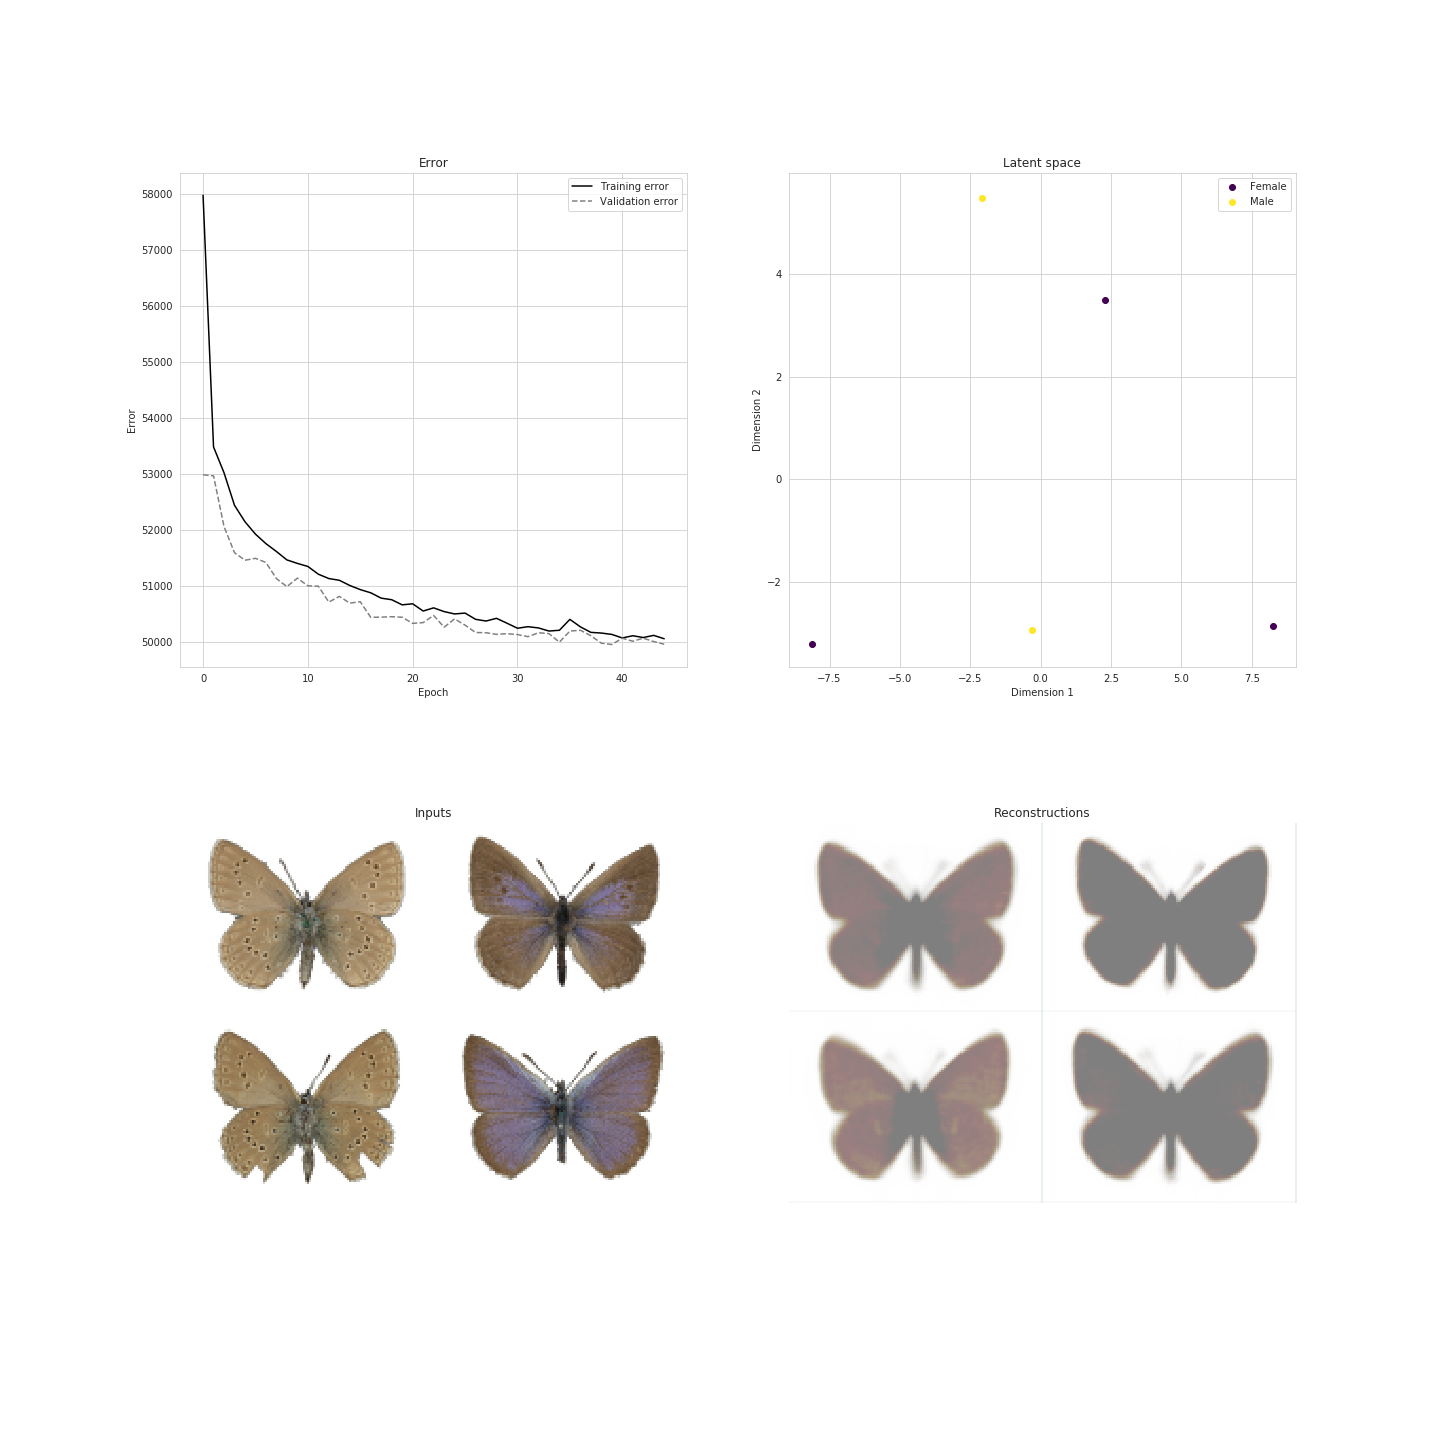

In [80]:
plot(train_losses,valid_losses,x,x_hat,z,batch,epoch,batchSize)

In [62]:
#from: https://stackoverflow.com/questions/48393608/pytorch-network-parameter-calculation

def count_parameters(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name, ':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name, ':', num_param)
            total_param += num_param
    return total_param
print('number of trainable parameters = ',count_parameters(net))

c1.weight : 64x3x7x7 = 9408
c1.bias : 64
c2.weight : 64x64x7x7 = 200704
c2.bias : 64
c3.weight : 128x64x3x3 = 73728
c3.bias : 128
ct1.weight : 128x64x3x3 = 73728
ct1.bias : 64
ct2.weight : 64x64x7x7 = 200704
ct2.bias : 64
ct3.weight : 64x3x7x7 = 9408
ct3.bias : 3
number of trainable parameters =  568067


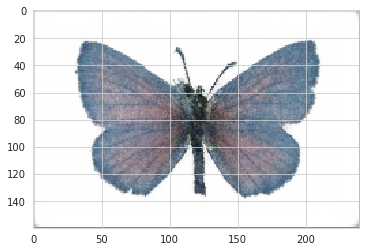

In [16]:
plt.imshow(x_hat[0].permute((1,2,0)).cpu().detach().numpy())

In [101]:


class FFNClassifier(BaseModel):
    def __init__(self,input_shape,hidden_units,output_classes):
        super(FFNClassifier, self).__init__()
        self.batchSize = input_shape[0]
        self.num_features = np.prod(input_shape[1:])
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.num_features,out_features=output_classes),
            #nn.ReLU()#,
            #nn.Linear(in_features=hidden_units,out_features=output_classes)
        )
        
    def forward(self, z):
        z = z.reshape((self.batchSize,self.num_features))
        z = self.classifier(z)
        return torch.softmax(z,dim=1)
classifier_net = FFNClassifier(input_shape=z.shape,hidden_units=100,output_classes=4)
#if cuda:
#    classifier_net = classifier_net.cuda()
    
classifier_net

FFNClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=235008, out_features=4, bias=True)
  )
)

In [102]:
classifier_optimizer = optim.SGD(net.parameters(), lr=0.0001)
classifier_loss = nn.CrossEntropyLoss()

In [107]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(loader.df['Sex'].values)

epochs = 10
net.eval()
c_train_losses = []
c_val_losses = []
for e in range(epochs):
    losses = []
    classifier_net.train()
    loader.trainSet()
    _, numBatches = loader.getIteratorInfo()
    for i in tqdm(range(numBatches)):
        x = loader.getNext()
        y = label_encoder.transform(x.data['Sex'].values)
        x = Variable(torch.from_numpy(x.imgs).float())
        y = Variable(torch.LongTensor(y))
        x = x.permute((0,3,1,2))
        if cuda:
            x = x.cuda()

        outputs = net(x)
        z = outputs['z'].view(batchSize,-1).cpu()
        preds = classifier_net(z)
        loss = classifier_loss(preds, y)
        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()
        losses += [loss.detach().numpy()]
    print(np.mean(losses))
    c_train_losses += [np.mean(losses)]
    
    losses = []
    classifier_net.eval()
    loader.validationSet()
    _, numBatches = loader.getIteratorInfo()
    for i in tqdm(range(numBatches)):
        x = loader.getNext()
        y = label_encoder.transform(x.data['Sex'].values)
        x = Variable(torch.from_numpy(x.imgs).float())
        y = Variable(torch.LongTensor(y))
        x = x.permute((0,3,1,2))
        if cuda:
            x = x.cuda()

        outputs = net(x)
        z = outputs['z'].view(batchSize,-1).cpu()
        preds = classifier_net(z)
        loss = classifier_loss(preds, y)
        losses += [loss.detach().numpy()]
    print(np.mean(losses))
    c_val_losses += [np.mean(losses)]

1.2125905


1.1159123


KeyboardInterrupt: 

In [106]:
preds,y

(tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 1.0591e-39, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00

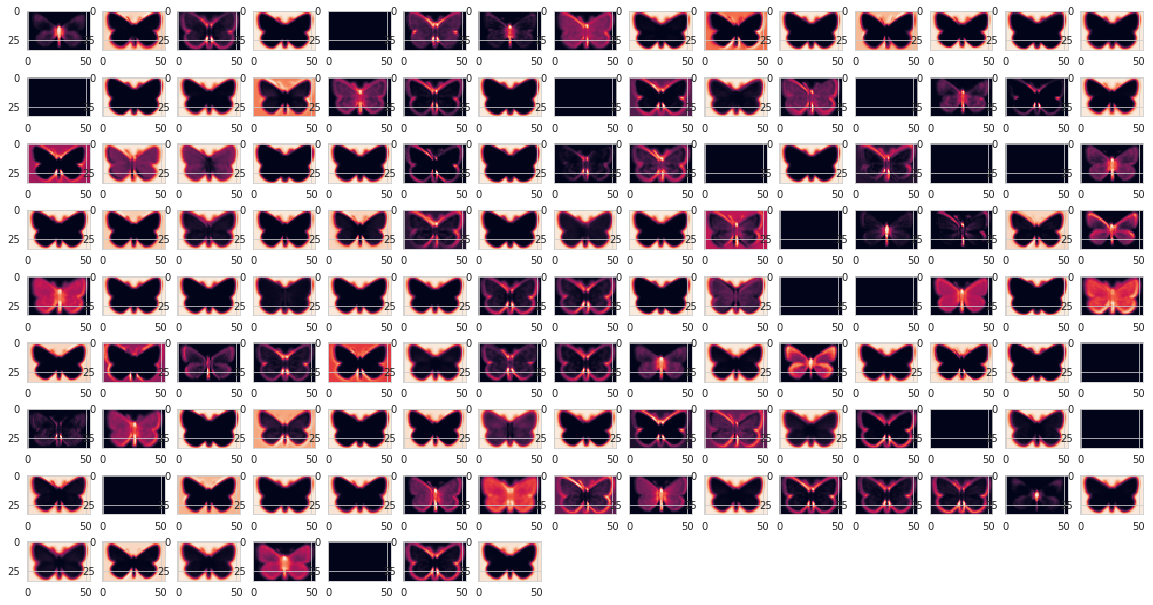

In [72]:
plt.figure(figsize=(20,12))
for i in range(1, 128):
    plt.subplot(10, 15, i)
    plt.imshow(z.mean(axis=0)[i])

In [71]:
z.mean(axis=0).shape

(128, 34, 54)

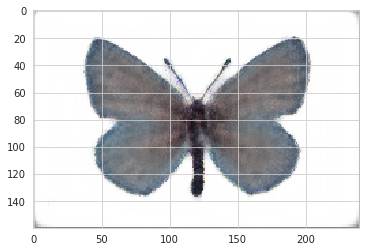

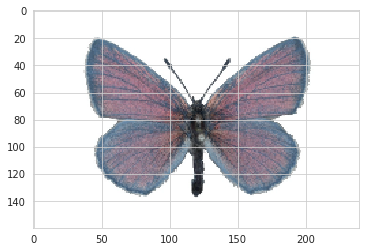

In [204]:
index = 3
plt.imshow(x_hat[index].permute(1,2,0).cpu().detach().numpy())
plt.figure()
plt.imshow(x[index].permute(1,2,0).cpu().detach().numpy())

In [90]:
x_hat[0].shape

torch.Size([3, 160, 240])

In [11]:
cuda

True